This notebook preprocesses, encodes, train_test splits, & scales data, then runs a variety of models to predict garment worker productivity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, scale
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

Preprocess data. Begin by checking for null values.

In [2]:
garment_prod = pd.read_csv("data/garments_worker_productivity.csv")
garment_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [3]:
garment_prod['wip'].describe()

count      691.000000
mean      1190.465991
std       1837.455001
min          7.000000
25%        774.500000
50%       1039.000000
75%       1252.500000
max      23122.000000
Name: wip, dtype: float64

The 'wip' column shows number of works in progress. Given the large number of nulls and that min = 7, assume nulls should be considered 0.

In [4]:
garment_prod['wip'] = garment_prod['wip'].fillna(0)

Convert 'date' to datetime to facilitate anlysis.

In [5]:
garment_prod['date'] = pd.to_datetime(garment_prod['date'])

Group predictor columns according to data type into three dataframes for preprocessing: nominal categorical, ordinal categorical, & numerical. 

In [6]:
# Select nominal categorical columns for encoding.
garment_nominal = garment_prod[['department', 'team']]
garment_nominal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   department  1197 non-null   object
 1   team        1197 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.8+ KB


In [7]:
# Select ordinal categorical columns for encoding.
garment_ordinal = garment_prod[['date', 'quarter', 'day']]
garment_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     1197 non-null   datetime64[ns]
 1   quarter  1197 non-null   object        
 2   day      1197 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 28.2+ KB


In [8]:
# Select numerical columns.
garment_numerical = garment_prod.iloc[:, 5:]
garment_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   targeted_productivity  1197 non-null   float64
 1   smv                    1197 non-null   float64
 2   wip                    1197 non-null   float64
 3   over_time              1197 non-null   int64  
 4   incentive              1197 non-null   int64  
 5   idle_time              1197 non-null   float64
 6   idle_men               1197 non-null   int64  
 7   no_of_style_change     1197 non-null   int64  
 8   no_of_workers          1197 non-null   float64
 9   actual_productivity    1197 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 93.6 KB


Encode nominal features, 'department' and 'team', using One Hot. First, check number of categories in each of these columns.

In [9]:
garment_nominal.iloc[:, 0].unique()

array(['sweing', 'finishing ', 'finishing'], dtype=object)

Some 'department' entries include a space at the end. Remove those spaces and correct mispelling of 'sewing'.

In [10]:
garment_nominal.iloc[:, 0].replace({'sweing': 'sewing', 'finishing ': 'finishing'}, inplace=True)
garment_nominal.iloc[:, 0].unique()

array(['sewing', 'finishing'], dtype=object)

In [11]:
team_categories = garment_nominal['team'].unique()
team_categories.sort(axis=0)
team_categories

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

Utilize get_dummies to encode nominal columns using OHE. Function drops orgininal columns.

In [12]:
garment_nom_encoded = pd.get_dummies(garment_nominal, columns = ['department', 'team'])
garment_nom_encoded.head()

,department_finishing,department_sewing,team_1,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [13]:
# Double check that all data were encoded.
garment_nom_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   department_finishing  1197 non-null   uint8
 1   department_sewing     1197 non-null   uint8
 2   team_1                1197 non-null   uint8
 3   team_2                1197 non-null   uint8
 4   team_3                1197 non-null   uint8
 5   team_4                1197 non-null   uint8
 6   team_5                1197 non-null   uint8
 7   team_6                1197 non-null   uint8
 8   team_7                1197 non-null   uint8
 9   team_8                1197 non-null   uint8
 10  team_9                1197 non-null   uint8
 11  team_10               1197 non-null   uint8
 12  team_11               1197 non-null   uint8
 13  team_12               1197 non-null   uint8
dtypes: uint8(14)
memory usage: 16.5 KB


Encode 'quarter' and 'day' using ordinal encoder. Use sequence of integers as values in dictionaries to map data in the "quarter" and "day" columns to integers in new columns.

In [14]:
# turn off chained assignments warning (false positive) because mapping to new columns is working.
pd.set_option('chained_assignment', None)
Quarter_dict = {'Quarter1': 1, 'Quarter2': 2, 'Quarter3': 3, 'Quarter4': 4, 'Quarter5': 5}
garment_ordinal['quarter_ordinal'] = garment_ordinal.loc[:, 'quarter'].map(Quarter_dict)


Day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
garment_ordinal['day_ordinal'] = garment_ordinal.loc[:, 'day'].map(Day_dict)
garment_ordinal.head()

,date,quarter,day,quarter_ordinal,day_ordinal
0,2015-01-01,Quarter1,Thursday,1,4
1,2015-01-01,Quarter1,Thursday,1,4
2,2015-01-01,Quarter1,Thursday,1,4
3,2015-01-01,Quarter1,Thursday,1,4
4,2015-01-01,Quarter1,Thursday,1,4


In [15]:
garment_ordinal.drop(labels=['quarter', 'day'], axis=1, inplace=True)
garment_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1197 non-null   datetime64[ns]
 1   quarter_ordinal  1197 non-null   int64         
 2   day_ordinal      1197 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 28.2 KB


To use datetime in regression, perform ordinal encoding by mapping with python's datetime.toordinal method.

In [16]:
from datetime import datetime 
garment_ordinal['date'] = garment_ordinal['date'].map(datetime.toordinal)

In [17]:
garment_ordinal['date'].describe()

count      1197.000000
mean     735633.456140
std          20.630062
min      735599.000000
25%      735616.000000
50%      735632.000000
75%      735652.000000
max      735668.000000
Name: date, dtype: float64

Concatenate encoded nominal and ordinal columns.

In [18]:
garment_categorical = pd.concat([garment_nom_encoded, garment_ordinal], axis=1)
garment_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   department_finishing  1197 non-null   uint8
 1   department_sewing     1197 non-null   uint8
 2   team_1                1197 non-null   uint8
 3   team_2                1197 non-null   uint8
 4   team_3                1197 non-null   uint8
 5   team_4                1197 non-null   uint8
 6   team_5                1197 non-null   uint8
 7   team_6                1197 non-null   uint8
 8   team_7                1197 non-null   uint8
 9   team_8                1197 non-null   uint8
 10  team_9                1197 non-null   uint8
 11  team_10               1197 non-null   uint8
 12  team_11               1197 non-null   uint8
 13  team_12               1197 non-null   uint8
 14  date                  1197 non-null   int64
 15  quarter_ordinal       1197 non-null   int64
 16  day_or

Drop last department & team columns to reduce impacts on regression models by the multicollinearity introduced by OHE encoding. The information in the deleted columns is still available to the model, though, because if the value of the deleted column was 1, the row will now have 0's for all remaining columns encoding that feature.

In [19]:
garment_categorical.drop(labels = ['department_sewing', 'team_12'], axis = 1, inplace = True)
garment_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   department_finishing  1197 non-null   uint8
 1   team_1                1197 non-null   uint8
 2   team_2                1197 non-null   uint8
 3   team_3                1197 non-null   uint8
 4   team_4                1197 non-null   uint8
 5   team_5                1197 non-null   uint8
 6   team_6                1197 non-null   uint8
 7   team_7                1197 non-null   uint8
 8   team_8                1197 non-null   uint8
 9   team_9                1197 non-null   uint8
 10  team_10               1197 non-null   uint8
 11  team_11               1197 non-null   uint8
 12  date                  1197 non-null   int64
 13  quarter_ordinal       1197 non-null   int64
 14  day_ordinal           1197 non-null   int64
dtypes: int64(3), uint8(12)
memory usage: 42.2 KB


Select predictor and target columns and split into train and test subsets, then scale (fit & transform) X_train and transform X_test using fit parameters from X_train.

In [20]:
# Concatenate categorical & numerical columns & save complete data set.
garment_prepped = pd.concat([garment_categorical, garment_numerical], axis=1)
# Drop target 'actual_productivity' from predictors.
X = garment_prepped.drop(columns = 'actual_productivity')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   department_finishing   1197 non-null   uint8  
 1   team_1                 1197 non-null   uint8  
 2   team_2                 1197 non-null   uint8  
 3   team_3                 1197 non-null   uint8  
 4   team_4                 1197 non-null   uint8  
 5   team_5                 1197 non-null   uint8  
 6   team_6                 1197 non-null   uint8  
 7   team_7                 1197 non-null   uint8  
 8   team_8                 1197 non-null   uint8  
 9   team_9                 1197 non-null   uint8  
 10  team_10                1197 non-null   uint8  
 11  team_11                1197 non-null   uint8  
 12  date                   1197 non-null   int64  
 13  quarter_ordinal        1197 non-null   int64  
 14  day_ordinal            1197 non-null   int64  
 15  targ

In [21]:
y = garment_prod['actual_productivity']

In [22]:
# Split into train & test subsets before scaling.
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 922 to 684
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   department_finishing   837 non-null    uint8  
 1   team_1                 837 non-null    uint8  
 2   team_2                 837 non-null    uint8  
 3   team_3                 837 non-null    uint8  
 4   team_4                 837 non-null    uint8  
 5   team_5                 837 non-null    uint8  
 6   team_6                 837 non-null    uint8  
 7   team_7                 837 non-null    uint8  
 8   team_8                 837 non-null    uint8  
 9   team_9                 837 non-null    uint8  
 10  team_10                837 non-null    uint8  
 11  team_11                837 non-null    uint8  
 12  date                   837 non-null    int64  
 13  quarter_ordinal        837 non-null    int64  
 14  day_ordinal            837 non-null    int64  
 15  targ

In [23]:
# Select predictors for scaling, including numerical and encoded ordinal columns.
X_train_scalable = X_train.drop(X.iloc[:, 0:12], axis = 1)
X_test_scalable = X_test.drop(X.iloc[:, 0:12], axis = 1)
# X_train_scalable.info()
X_test_scalable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 700 to 1048
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   360 non-null    int64  
 1   quarter_ordinal        360 non-null    int64  
 2   day_ordinal            360 non-null    int64  
 3   targeted_productivity  360 non-null    float64
 4   smv                    360 non-null    float64
 5   wip                    360 non-null    float64
 6   over_time              360 non-null    int64  
 7   incentive              360 non-null    int64  
 8   idle_time              360 non-null    float64
 9   idle_men               360 non-null    int64  
 10  no_of_style_change     360 non-null    int64  
 11  no_of_workers          360 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 36.6 KB


In [24]:
# Scale ordinal & numerical columns in X_train,convert ndarray output to dataframe as float dtype, & name columns.
scaler = StandardScaler()
X_train_scaling = scaler.fit_transform(X_train_scalable)
X_train_scaled = pd.DataFrame(X_train_scaling)
X_train_scaled = X_train_scaled.astype('float')
X_train_scaled.columns = ['date', 'quarter_ordinal','day_ordinal', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   837 non-null    float64
 1   quarter_ordinal        837 non-null    float64
 2   day_ordinal            837 non-null    float64
 3   targeted_productivity  837 non-null    float64
 4   smv                    837 non-null    float64
 5   wip                    837 non-null    float64
 6   over_time              837 non-null    float64
 7   incentive              837 non-null    float64
 8   idle_time              837 non-null    float64
 9   idle_men               837 non-null    float64
 10  no_of_style_change     837 non-null    float64
 11  no_of_workers          837 non-null    float64
dtypes: float64(12)
memory usage: 78.6 KB


In [25]:
# Use fit paramaters from X_train to transform X_test, then convert back to df.
X_test_scaling = scaler.transform(X_test_scalable)
X_test_scaled = pd.DataFrame(X_test_scaling)
X_test_scaled = X_test_scaled.astype('float')
X_test_scaled.columns = ['date', 'quarter_ordinal','day_ordinal', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']
X_test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   360 non-null    float64
 1   quarter_ordinal        360 non-null    float64
 2   day_ordinal            360 non-null    float64
 3   targeted_productivity  360 non-null    float64
 4   smv                    360 non-null    float64
 5   wip                    360 non-null    float64
 6   over_time              360 non-null    float64
 7   incentive              360 non-null    float64
 8   idle_time              360 non-null    float64
 9   idle_men               360 non-null    float64
 10  no_of_style_change     360 non-null    float64
 11  no_of_workers          360 non-null    float64
dtypes: float64(12)
memory usage: 33.9 KB


Select binary columns (encoded nominal features) in X_train and X_test, then concatenate with scaled columns to make complete train and test dataframes. 

In [26]:
X_train_binary = X_train.iloc[:, 0:12]
X_test_binary = X_test.iloc[:, 0:12]
# X_test_binary.info()
X_train_binary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 922 to 684
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   department_finishing  837 non-null    uint8
 1   team_1                837 non-null    uint8
 2   team_2                837 non-null    uint8
 3   team_3                837 non-null    uint8
 4   team_4                837 non-null    uint8
 5   team_5                837 non-null    uint8
 6   team_6                837 non-null    uint8
 7   team_7                837 non-null    uint8
 8   team_8                837 non-null    uint8
 9   team_9                837 non-null    uint8
 10  team_10               837 non-null    uint8
 11  team_11               837 non-null    uint8
dtypes: uint8(12)
memory usage: 16.3 KB


In [27]:
# Reset index on binary dataframes to match indexing on scaled dataframes, whose indexing was reset during scaling process.
X_train_binary.reset_index(drop = True, inplace = True)
X_test_binary.reset_index(drop = True, inplace = True)

In [28]:
X_train = pd.concat([X_train_binary, X_train_scaled], axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   department_finishing   837 non-null    uint8  
 1   team_1                 837 non-null    uint8  
 2   team_2                 837 non-null    uint8  
 3   team_3                 837 non-null    uint8  
 4   team_4                 837 non-null    uint8  
 5   team_5                 837 non-null    uint8  
 6   team_6                 837 non-null    uint8  
 7   team_7                 837 non-null    uint8  
 8   team_8                 837 non-null    uint8  
 9   team_9                 837 non-null    uint8  
 10  team_10                837 non-null    uint8  
 11  team_11                837 non-null    uint8  
 12  date                   837 non-null    float64
 13  quarter_ordinal        837 non-null    float64
 14  day_ordinal            837 non-null    float64
 15  target

In [29]:
X_test = pd.concat([X_test_binary, X_test_scaled], axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   department_finishing   360 non-null    uint8  
 1   team_1                 360 non-null    uint8  
 2   team_2                 360 non-null    uint8  
 3   team_3                 360 non-null    uint8  
 4   team_4                 360 non-null    uint8  
 5   team_5                 360 non-null    uint8  
 6   team_6                 360 non-null    uint8  
 7   team_7                 360 non-null    uint8  
 8   team_8                 360 non-null    uint8  
 9   team_9                 360 non-null    uint8  
 10  team_10                360 non-null    uint8  
 11  team_11                360 non-null    uint8  
 12  date                   360 non-null    float64
 13  quarter_ordinal        360 non-null    float64
 14  day_ordinal            360 non-null    float64
 15  target

Try different methods to predict garment worker productivity. Start with linear regression.

In [30]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
#calculate R2 and format as float to 4 decimal places
print('linear regression R2 = {:.4f}'.format(linear_regression.score(X_test, y_test)))

linear regression R2 = 0.2772


See if performance can be improved by reducing number of predictor dimensions with principal component analysis. Try principal component regression (PCR) with k-fold cross validation to optimize number of principal components.

In [31]:
#Shuffle df for cross-validation so all folds are similar (train_test_split shuffles by default, but that follows cv).
garment_shuf = shuffle(garment_prepped, random_state=7)
garment_shuf.head()

,department_finishing,team_1,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,...,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
657,0,0,0,0,0,0,0,0,0,0,...,0.8,22.52,1388.0,6720,88,0.0,0,0,56.0,0.900800
98,0,0,0,0,0,0,1,0,0,0,...,0.8,11.61,910.0,4470,38,0.0,0,0,31.5,0.800077
63,1,0,0,0,1,0,0,0,0,0,...,0.8,3.94,0.0,3840,0,0.0,0,0,16.0,0.893663
905,0,0,0,0,0,0,0,0,0,0,...,0.8,15.26,1062.0,4080,50,0.0,0,0,34.0,0.800402
782,0,0,1,0,0,0,0,0,0,0,...,0.8,22.52,12.0,6900,0,0.0,0,0,57.5,0.432123


In [32]:
y_pca = garment_shuf['actual_productivity']
# X_pca = garment_shuf[['smv', 'wip', 'over_time', 'incentive', 'no_of_style_change', 'no_of_workers']]
# columns to drop , 'targeted_productivity','idle_time',
X_pca = garment_shuf.drop(columns = ['actual_productivity'])
X_pca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197 entries, 657 to 175
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   department_finishing   1197 non-null   uint8  
 1   team_1                 1197 non-null   uint8  
 2   team_2                 1197 non-null   uint8  
 3   team_3                 1197 non-null   uint8  
 4   team_4                 1197 non-null   uint8  
 5   team_5                 1197 non-null   uint8  
 6   team_6                 1197 non-null   uint8  
 7   team_7                 1197 non-null   uint8  
 8   team_8                 1197 non-null   uint8  
 9   team_9                 1197 non-null   uint8  
 10  team_10                1197 non-null   uint8  
 11  team_11                1197 non-null   uint8  
 12  date                   1197 non-null   int64  
 13  quarter_ordinal        1197 non-null   int64  
 14  day_ordinal            1197 non-null   int64  
 15  tar

In [33]:
# Scale the predictor variables and perform PCA on them.
pca = PCA()
X_reduced = pca.fit_transform(scale(X_pca))
X_reduced.shape

(1197, 24)

In [34]:
# Use k-fold cross-validation to evaluate model performance using k = 10 folds, repeated 3 times.
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr = LinearRegression()
mse = []
mse

[]

In [35]:
# Calculate the average of MSE from each split without using any of the principal components.
score = -1*model_selection.cross_val_score(regr,
           np.ones((len(X_reduced),1)), y_pca, cv=cv,
           scoring='neg_mean_squared_error').mean()    
mse.append(score)
mse

[0.0304612646170554]

In [36]:
# Calculate MSE using cross-validation, adding one component at a time until all components are used.
for i in np.arange(1, 25):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced[:,:i], y_pca, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
mse

[0.0304612646170554,
 0.03013425467543644,
 0.026962380272945907,
 0.026709076457153855,
 0.02579025293102626,
 0.02571995887735717,
 0.025503338918577312,
 0.02545658761885681,
 0.025474846884656382,
 0.025514950770285854,
 0.0252301735210446,
 0.025279677131771358,
 0.025065077764971362,
 0.02493777521214016,
 0.024485339096170795,
 0.024563624883597077,
 0.024637182940229832,
 0.023430499717833723,
 0.02322438451232785,
 0.02329475639507349,
 0.023019173118132008,
 0.022983296012669623,
 0.022808333631028726,
 0.022240603257469682,
 0.02186682888543295]

Text(0.5, 1.0, 'actual_productivity')

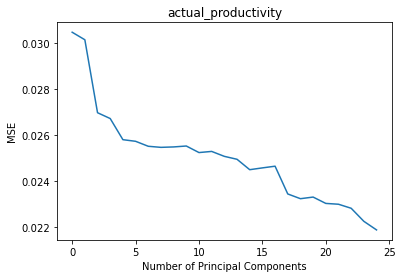

In [37]:
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('actual_productivity')

In [38]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 15.63,  22.74,  29.  ,  34.39,  39.28,  43.93,  48.54,  53.12,
        57.7 ,  62.27,  66.84,  71.36,  75.79,  80.2 ,  83.97,  87.62,
        90.8 ,  93.91,  96.16,  97.87,  99.05,  99.55,  99.89, 100.  ])

MSE decreases with each additional component up to 7 (the first MSE reflects no principle components), so can try 7 principal components in regression. However, the first 7 principal components only explay 53% of the variance. So can also try 14 principal components, which explain about 84% of the variance.

In [39]:
# Split into train & test subsets
X_pca_train,X_pca_test,y_pca_train,y_pca_test = train_test_split(X_pca, y_pca, test_size=0.3, random_state=0) 
# run PCA on train subset, scaling each predictor by fitting & transforming.
X_reduced_train = pca.fit_transform(scale(X_pca_train))

In [40]:
# Try regression using first 7 principal components.
regr7 = LinearRegression()
# run PCA on test subset, transforming (with fit from X_pca_train) & selecting first 7 principal components.
X_reduced_test7 = pca.transform(scale(X_pca_test))[:,:7]
# train model on first 7 principal components
regr7.fit(X_reduced_train[:,:7], y_pca_train)
# calculate R2 by using trained model to predict target values and compare to actual values.
print('PC7 R2 = {:.4f}'.format(regr7.score(X_reduced_test7, y_pca_test)))

PC7 R2 = 0.2354


In [41]:
# Try regression with 14 principal components.
regr14 = LinearRegression()
# run PCA on test subset, transforming (with fit from X_pca_train) & selecting first 14 principal components.
X_reduced_test14 = pca.transform(scale(X_pca_test))[:,:14]
# train model on first 14 principal components
regr14.fit(X_reduced_train[:,:14], y_pca_train)
# calculate R2 by using trained model to predict target values and compare to actual values.
print('PC14 R2 = {:.4f}'.format(regr14.score(X_reduced_test14, y_pca_test)))

PC14 R2 = 0.2326


The PCA did not improve model performance, so next try ridge & lasso together. ElasticNet does this. Use with cross-validation. 

In [42]:
# Use default value balancing ridge & lasso (in sklearn set by default l1 ratio = 0.5, but elsewhere called 'alpha'). 
e_net = ElasticNet()
e_net.fit(X_train, y_train)
print('ElasticNet R2 = {:.4f}'.format(e_net.score(X_test, y_test)))

ElasticNet R2 = -0.0011


Performance was poor, so let cross-validation search for better parameters.

In [43]:
e_netCV = ElasticNetCV(cv = 10)
e_netCV.fit(X_train, y_train)
print('ElasticNetCV R2 = {:.4f}'.format(e_netCV.score(X_test, y_test)))

ElasticNetCV R2 = 0.2828


This is the highest R2 of all models so far, greater than linear regression R2 by about 0.0056. What alpha and lambda values were best?

In [44]:
e_netCV.l1_ratio_

0.5

Cross-validation didn't change the balance between ridge and lasso.

In [45]:
e_netCV.alpha_

0.0013162279856429068

The sklearn 'alpha' value near 0 indicates that only a small amount of regularization was performed, and this seems to have improved performance slightly over non-regularized linear regression.

In [46]:
# take a look at the model coefficients
e_netCV.coef_

array([ 0.00875903,  0.05974603,  0.02074828,  0.06216108,  0.04390612,
        0.        , -0.05361424, -0.049864  , -0.02227702, -0.01713028,
       -0.02815538, -0.05665452, -0.01779714, -0.        ,  0.00166308,
        0.06104177, -0.07392782,  0.00682659, -0.01961632,  0.01066051,
        0.01075409, -0.02969781, -0.01155144,  0.08012466])

Not surprisingly, the high end of the coefficient range was found in several different predictors.

Try a neural network to see if it predicts productivity better.

In [47]:
import tensorflow.python.keras.backend
from tensorflow.python.keras import initializers, optimizers, regularizers,layers
# from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.constraints import maxnorm
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier

In [48]:
model = Sequential()

In [49]:
#InputLayer
model.add(Dense(12, input_dim = 24, activation='relu'))

In [50]:
#Hidden Layers
model.add(Dense(5, activation='relu'))

In [51]:
#Output Layer
model.add(Dense(1, activation='relu'))

In [52]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [53]:
history = model.fit(X_train, y_train, batch_size=35, epochs=20, validation_data=(X_test, y_test),verbose=1)

Epoch 1/20
24/24 [==============================] - 1s 17ms/step - loss: 0.4460 - mse: 0.4460 - val_loss: 0.3900 - val_mse: 0.3900
Epoch 2/20
24/24 [==============================] - 0s 3ms/step - loss: 0.3628 - mse: 0.3628 - val_loss: 0.3546 - val_mse: 0.3546
Epoch 3/20
24/24 [==============================] - 0s 4ms/step - loss: 0.3320 - mse: 0.3320 - val_loss: 0.3190 - val_mse: 0.3190
Epoch 4/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2884 - mse: 0.2884 - val_loss: 0.2578 - val_mse: 0.2578
Epoch 5/20
24/24 [==============================] - 0s 3ms/step - loss: 0.1897 - mse: 0.1897 - val_loss: 0.1273 - val_mse: 0.1273
Epoch 6/20
24/24 [==============================] - 0s 4ms/step - loss: 0.0921 - mse: 0.0921 - val_loss: 0.0683 - val_mse: 0.0683
Epoch 7/20
24/24 [==============================] - 0s 4ms/step - loss: 0.0651 - mse: 0.0651 - val_loss: 0.0562 - val_mse: 0.0562
Epoch 8/20
24/24 [==============================] - 0s 4ms/step - loss: 0.0554 - mse: 0.0

Evaluate model by computing mean squarred error for neural network and for ElasticNetCV.

In [54]:
# MSE for the neural network model
test_MSE = model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 3ms/step - loss: 0.0306 - mse: 0.0306


In [55]:
#MSE for ElasticNetCV
pred = e_netCV.predict(X_test)
mean_squared_error(y_test, pred)

0.020700031146451758

ElasticNet with cross-validation produced a smaller mean squarred error, so performed a little better than this initial try with a neural network.